In [1]:
# IMPORTANT: Restart your kernel first, then run this cell
import torch
import gc

# Clear all CUDA memory
torch.cuda.empty_cache()
gc.collect()

# Check available memory
print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

GPU Memory Available: 5.61 GB
GPU Memory Allocated: 0.00 GB


In [2]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.1.3
matplotlib version: 3.10.8
tiktoken version: 0.12.0
torch version: 2.9.1
tqdm version: 4.67.1
tensorflow version: 2.19.1


In [3]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instructions/instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
print("Example entry:\n", data[50])
print("Another example entry:\n", data[999])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}
Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [10]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry["output"]}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_draft_1(batch, pad_token_id=50256, device='cuda'):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')


In [14]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device='cuda'):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]], device='cuda:0')


In [16]:
# Cross Entropy loss function ignores the index -100

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


In [17]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [18]:
from torch.utils.data import DataLoader

num_workers=0
batch_size=1

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [19]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([1, 40]) torch.Size([1, 40])
torch.Size([1, 50]) torch.Size([1, 50])
torch.Size([1, 71]) torch.Size([1, 71])
torch.Size([1, 56]) torch.Size([1, 56])
torch.Size([1, 66]) torch.Size([1, 66])
torch.Size([1, 58]) torch.Size([1, 58])
torch.Size([1, 58]) torch.Size([1, 58])
torch.Size([1, 49]) torch.Size([1, 49])
torch.Size([1, 82]) torch.Size([1, 82])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 52]) torch.Size([1, 52])
torch.Size([1, 48]) torch.Size([1, 48])
torch.Size([1, 64]) torch.Size([1, 64])
torch.Size([1, 83]) torch.Size([1, 83])
torch.Size([1, 55]) torch.Size([1, 55])
torch.Size([1, 44]) torch.Size([1, 44])
torch.Size([1, 55]) torch.Size([1, 55])
torch.Size([1, 57]) torch.Size([1, 57])
torch.Size([1, 53]) torch.Size([1, 53])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 50]) torch.Size([1, 50])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 54]) torch.Size([1, 54])
torch.Size([1, 64]) torch.Size([1, 64])
torch.Size([1, 49]) torch.

In [20]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,  8291, 17660,   705,    40,   716,  3772,
            6,   656,  4141,    13,   198,   198, 21017, 18261,    25,   198,
          464,  4141, 11059,   286,   705,    40,   716,  3772,     6,   318,
          705, 40932,   424,   271,   339,   495,  2821,     6,   357,   361,
          262, 10834,   318,  4257,     8,   393,   705, 40932,   424,   271,
          339,   495,  1904,     6,   357,   361,   262, 10834,   318,  4048,
          737], device='cuda:0')


In [21]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198,  8291, 17660,   705,    40,   716,  3772,     6,
          656,  4141,    13,   198,   198, 21017, 18261,    25,   198,   464,
         4141, 11059,   286,   705,    40,   716,  3772,     6,   318,   705,
        40932,   424,   271,   339,   495,  2821,     6,   357,   361,   262,
        10834,   318,  4257,     8,   393,   705, 40932,   424,   271,   339,
          495,  1904,     6,   357,   361,   262, 10834,   318,  4048,   737,
        50256], device='cuda:0')


In [22]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();
model = model.to(device)

2025-12-15 20:49:14.641378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765811954.660965  134547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765811954.667199  134547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765811954.684334  134547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765811954.684371  134547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765811954.684373  134547 computation_placer.cc:177] computation placer alr

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [23]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [24]:
from previous_chapters import (
    generate,
    token_ids_to_text,
    text_to_token_ids
)

# token_ids = generate(
#     model=model,
#     idx=text_to_token_ids(input_text, tokenizer),
#     max_new_tokens=35,
#     context_size=BASE_CONFIG["context_length"],
#     eos_id=50256
# )
# generated_text = token_ids_to_text(token_ids, tokenizer)

In [25]:
# response_text = (
#     generated_text[len(input_text):]
#     .replace("### Response:", "")
#     .strip()
# )
# print(response_text)

In [26]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple,
    train_model_simple_with_grad_accum
)

# model.to(device)
# torch.manual_seed(123)

# with torch.no_grad():
#     train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
#     val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

In [27]:
# device = torch.device("cuda")
# torch.cuda.empty_cache()

# import time

# start_time = time.time()

# torch.manual_seed(123)

# # optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
# optimizer = torch.optim.AdamW(
#     model.parameters(), 
#     lr=0.00005 / 4,  # Divide by accumulation_steps
#     weight_decay=0.1
# )

# num_epochs = 2

# train_losses, val_losses, tokens_seen = train_model_simple_with_grad_accum(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context=format_input(val_data[0]), tokenizer=tokenizer, accumulation_steps=4
# )

# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


MEMORY REQUIREMENTS ESTIMATE
model_parameters........................ 1.51 GB
gradients............................... 1.51 GB
activations_estimate.................... 0.00 GB
optimizer_standard...................... 3.03 GB
optimizer_8bit.......................... 0.76 GB
total_standard.......................... 6.06 GB
total_8bit.............................. 3.79 GB

TRAINING CONFIGURATION
Model: GPT-2 355M
Strategy: 8-bit Adam + Gradient Checkpointing + Mixed Precision
Gradient Accumulation Steps: 8 (effective batch size)
Learning Rate: 0.00005 / 8 = 0.0000063


GPU: NVIDIA GeForce RTX 2060
Total Memory: 5.61 GB
Accumulation Steps: 8
Effective Batch Size: 8

✓ Gradient checkpointing enabled
✓ Using 8-bit AdamW optimizer (75% memory reduction)

Epoch 1/2
Ep 1 (Step 000000): Train loss 3.900, Val loss 3.867
Ep 1 (Step 000005): Train loss 2.897, Val loss 2.947
Ep 1 (Step 000010): Train loss 2.242, Val loss 2.460
Ep 1 (Step 000015): Train loss 1.965, Val loss 2.045
Ep 1 (Step 000020):

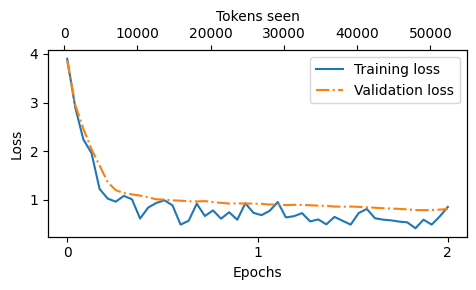

In [28]:
# ============================================================================
# MEMORY-EFFICIENT TRAINING FOR GPT-2 355M
# ============================================================================

# First, install bitsandbytes for 8-bit optimizer (75% memory reduction)
# Run this in terminal: pip install bitsandbytes

from memory_efficient_trainer import (
    train_memory_efficient,
    estimate_memory_requirements,
    print_memory_usage
)
import time

# Clear memory before training
torch.cuda.empty_cache()
gc.collect()

# Estimate memory requirements
print("\n" + "="*60)
print("MEMORY REQUIREMENTS ESTIMATE")
print("="*60)
memory_est = estimate_memory_requirements(model, batch_size=1, seq_length=1024)
for key, value in memory_est.items():
    print(f"{key:.<40} {value:.2f} GB")

print("\n" + "="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Model: GPT-2 355M")
print(f"Strategy: 8-bit Adam + Gradient Checkpointing + Mixed Precision")
print(f"Gradient Accumulation Steps: 8 (effective batch size)")
print(f"Learning Rate: 0.00005 / 8 = {0.00005/8:.7f}")
print("="*60 + "\n")

start_time = time.time()
torch.manual_seed(123)

# Train with memory optimizations
train_losses, val_losses, tokens_seen = train_memory_efficient(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=2,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer,
    learning_rate=0.00005,
    accumulation_steps=8,  # Increase if still getting OOM
    use_8bit_optimizer=True,  # Set to False if bitsandbytes not available
    use_gradient_checkpointing=True
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60

print(f"\n{'='*60}")
print(f"✓ Training completed in {execution_time_minutes:.2f} minutes")
print(f"{'='*60}\n")

# Print final memory usage
print_memory_usage()

# Plot losses
from previous_chapters import plot_losses
epochs_tensor = torch.linspace(0, 2, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [30]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is very fast.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is 

In [31]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:42<00:00,  1.07it/s]
